# Import packages

In [15]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# https://machinelearningmastery.com/how-to-develop-a-generative-adversarial-network-for-an-mnist-handwritten-digits-from-scratch-in-keras/

In [2]:
from tensorflow.keras.optimizers import Adam
from keras.models import load_model, Sequential
from keras.layers import Dense, Reshape, Dropout, Activation, Conv2D,\
                         Conv2DTranspose, MaxPooling2D, Flatten, LeakyReLU

import numpy as np
import matplotlib.pyplot as plt

# Utility function

In [3]:
def uncompressArray(file_dir):
  uncompressed_data = []
  with open(file_dir, 'rb') as f:
    loaded_file = np.load(f)
    ks = list(loaded_file.keys())
    print("First, check the data!")
    print(f"Keys: {ks}")
    ans = input("Please enter 'y' if you want to proceed: ")
    if ans == 'y':
      print("\nloading data !")
      for k in ks:
        uncompressed_data.append(loaded_file[k].copy())
        print(f"load: {k}")
    else:
      print("data is not loaded!")
  return uncompressed_data

def reshape_data(X):
  X = X.reshape(X.shape[0], X.shape[1], X.shape[2], 1)
  return X

# Define models (Disc, Gen and GAN)

In [4]:
# define the standalone discriminator model
def define_discriminator(in_shape=(28,28,1)):
	model = Sequential()
	model.add(Conv2D(64, (3,3), strides=(2, 2), padding='same', input_shape=in_shape))
	model.add(LeakyReLU(alpha=0.2))
	model.add(Dropout(0.4))
	model.add(Conv2D(64, (3,3), strides=(2, 2), padding='same'))
	model.add(LeakyReLU(alpha=0.2))
	model.add(Dropout(0.4))
	model.add(Flatten())
	model.add(Dense(1, activation='sigmoid'))
	# compile model
	opt = Adam(lr=0.0002, beta_1=0.5)
	model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
	return model

# define the standalone generator model
def define_generator(latent_dim):
	model = Sequential()
	# foundation for 7x7 image
	n_nodes = 128 * 7 * 7
	model.add(Dense(n_nodes, input_dim=latent_dim))
	model.add(LeakyReLU(alpha=0.2))
	model.add(Reshape((7, 7, 128)))
	# upsample to 14x14
	model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
	model.add(LeakyReLU(alpha=0.2))
	# upsample to 28x28
	model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
	model.add(LeakyReLU(alpha=0.2))
	model.add(Conv2D(1, (7,7), activation='sigmoid', padding='same'))
	return model

# define the combined generator and discriminator model, for updating the generator
def define_gan(g_model, d_model):
	# make weights in the discriminator not trainable
	d_model.trainable = False
	# connect them
	model = Sequential()
	# add generator
	model.add(g_model)
	# add the discriminator
	model.add(d_model)
	# compile model
	opt = Adam(lr=0.0002, beta_1=0.5)
	model.compile(loss='binary_crossentropy', optimizer=opt)
	return model

# Define training functions

In [5]:
# select real samples
def generate_real_samples(dataset, n_samples):
  # choose random instances
  ix = np.random.randint(0, dataset.shape[0], n_samples)
  # retrieve selected images
  X = dataset[ix]
  # generate 'real' class labels (1)
  y = np.ones((n_samples, 1))
  return X, y

# generate points in latent space as input for the generator
def generate_latent_points(latent_dim, n_samples):
	# generate points in the latent space
	x_input = np.random.randn(latent_dim * n_samples)
	# reshape into a batch of inputs for the network
	x_input = x_input.reshape(n_samples, latent_dim)
	return x_input

# use the generator to generate n fake examples, with class labels
def generate_fake_samples(g_model, latent_dim, n_samples):
	# generate points in latent space
	x_input = generate_latent_points(latent_dim, n_samples)
	# predict outputs
	X = g_model.predict(x_input)
	# create 'fake' class labels (0)
	y = np.zeros((n_samples, 1))
	return X, y

# create and save a plot of generated images (reversed grayscale)
def save_plot(examples, epoch, n=10):
	# plot images
	for i in range(n * n):
		# define subplot
		plt.subplot(n, n, 1 + i)
		# turn off axis
		plt.axis('off')
		# plot raw pixel data
		plt.imshow(examples[i, :, :, 0], cmap='gray_r')
	# save plot to file
	filename = 'generated_plot_e%03d.png' % (epoch+1)
	plt.savefig(filename)
	plt.close()

# evaluate the discriminator, plot generated images, save generator model
def summarize_performance(epoch, g_model, d_model, dataset, latent_dim, n_samples=100, \
                          model_dir='/content/drive/MyDrive/PhD/Szeged22_paper/Atca_Cyber_long_paper/saved_models/'):
  # prepare real samples
  X_real, y_real = generate_real_samples(dataset, n_samples)
  # evaluate discriminator on real examples
  _, acc_real = d_model.evaluate(X_real, y_real, verbose=0)
  # prepare fake examples
  x_fake, y_fake = generate_fake_samples(g_model, latent_dim, n_samples)
  # evaluate discriminator on fake examples
  _, acc_fake = d_model.evaluate(x_fake, y_fake, verbose=0)
  # summarize discriminator performance
  print('>Accuracy real: %.0f%%, fake: %.0f%%' % (acc_real*100, acc_fake*100))
  # save plot
  save_plot(x_fake, epoch)
  # save the generator model tile file
  filename = model_dir + 'generator_model_%03d.h5' % (epoch + 1)
  g_model.save(filename)
  filename = model_dir + 'discriminator_model_%03d.h5' % (epoch + 1)
  d_model.save(filename)

# train the generator and discriminator
def train(g_model, d_model, gan_model, dataset, latent_dim, n_epochs=100, n_batch=256, \
          model_dir='/content/drive/MyDrive/PhD/Szeged22_paper/Atca_Cyber_long_paper/saved_models/'):
  bat_per_epo = int(dataset.shape[0] / n_batch)
  half_batch = int(n_batch / 2)
  # manually enumerate epochs
  for i in range(n_epochs):
    print(f'epoch: {i+1}')
    # enumerate batches over the training set
    for j in range(bat_per_epo):
      # get randomly selected 'real' samples
      X_real, y_real = generate_real_samples(dataset, half_batch)
      # generate 'fake' examples
      X_fake, y_fake = generate_fake_samples(g_model, latent_dim, half_batch)
      # create training set for the discriminator
      X, y = np.vstack((X_real, X_fake)), np.vstack((y_real, y_fake))
      # update discriminator model weights
      d_loss, _ = d_model.train_on_batch(X, y)
      # prepare points in latent space as input for the generator
      X_gan = generate_latent_points(latent_dim, n_batch)
      # create inverted labels for the fake samples
      y_gan = np.ones((n_batch, 1))
      # update the generator via the discriminator's error
      g_loss = gan_model.train_on_batch(X_gan, y_gan)
      # summarize loss on this batch
    # evaluate the model performance, sometimes
    if (i+1) % 25 == 0:
      print('\n>%d, %d/%d, d=%.3f, g=%.3f' % (i+1, j+1, bat_per_epo, d_loss, g_loss))
      summarize_performance(i, g_model, d_model, dataset, latent_dim, model_dir=model_dir)

# Load (letters) data

## Import data

In [6]:
data_file = '/content/drive/MyDrive/PhD/Szeged22_paper/Atca_Cyber_long_paper/data/clean_data.npz'

X_clean_train, X_clean_test, Y_clean_train, Y_clean_test = uncompressArray(data_file)

First, check the data!
Keys: ['X_clean_train', 'X_clean_test', 'Y_clean_train', 'Y_clean_test']
Please enter 'y' if you want to proceed: y

loading data !
load: X_clean_train
load: X_clean_test
load: Y_clean_train
load: Y_clean_test


In [7]:
print(X_clean_train.shape, X_clean_test.shape, Y_clean_train.shape, Y_clean_test.shape)

(401302, 28, 28, 1) (10000, 28, 28, 1) (401302,) (10000,)


## Create letters dataset > for GAN training

## Normalize data

In [8]:
# extract only one channel
X_train = X_clean_train[:,:,:,0]/255.

X_train.shape

(401302, 28, 28)

## Reshape data

In [9]:
X_train = reshape_data(X_train)

X_train.shape

(401302, 28, 28, 1)

# Train GAN

In [11]:
# size of the latent space
latent_dim = 100
# create the discriminator
d_model = define_discriminator(in_shape=X_train.shape[1:])
# create the generator
g_model = define_generator(latent_dim)
# create the gan
gan_model = define_gan(g_model, d_model)
# load image data
dataset = X_train.copy() #load_real_samples() # X_train (no need for load_real_samples)
# train model
train(g_model, d_model, gan_model, dataset, latent_dim)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


epoch: 1
epoch: 2
epoch: 3
epoch: 4
epoch: 5
epoch: 6
epoch: 7
epoch: 8
epoch: 9
epoch: 10
epoch: 11
epoch: 12
epoch: 13
epoch: 14
epoch: 15
epoch: 16
epoch: 17
epoch: 18
epoch: 19
epoch: 20
epoch: 21
epoch: 22
epoch: 23
epoch: 24
epoch: 25

>25, 1567/1567, d=0.692, g=0.666
>Accuracy real: 83%, fake: 29%
epoch: 26
epoch: 27
epoch: 28
epoch: 29
epoch: 30
epoch: 31
epoch: 32
epoch: 33
epoch: 34
epoch: 35
epoch: 36
epoch: 37
epoch: 38
epoch: 39
epoch: 40
epoch: 41
epoch: 42
epoch: 43
epoch: 44
epoch: 45
epoch: 46
epoch: 47
epoch: 48
epoch: 49
epoch: 50

>50, 1567/1567, d=0.695, g=0.676
>Accuracy real: 53%, fake: 66%
epoch: 51
epoch: 52
epoch: 53
epoch: 54
epoch: 55
epoch: 56
epoch: 57
epoch: 58
epoch: 59
epoch: 60
epoch: 61
epoch: 62
epoch: 63
epoch: 64
epoch: 65
epoch: 66
epoch: 67
epoch: 68
epoch: 69
epoch: 70
epoch: 71
epoch: 72
epoch: 73
epoch: 74
epoch: 75

>75, 1567/1567, d=0.692, g=0.702
>Accuracy real: 14%, fake: 94%
epoch: 76
epoch: 77
epoch: 78
epoch: 79
epoch: 80
epoch: 81
epoc

# Samples generation

In [12]:
main_models_dir = '/content/drive/MyDrive/PhD/Szeged22_paper/Atca_Cyber_long_paper/saved_models/'

In [14]:
# example of loading the generator model and generating images
from keras.models import load_model


# generate points in latent space as input for the generator
def generate_latent_points(latent_dim, n_samples):
	# generate points in the latent space
	x_input = np.random.randn(latent_dim * n_samples)
	# reshape into a batch of inputs for the network
	x_input = x_input.reshape(n_samples, latent_dim)
	return x_input

# create and save a plot of generated images (reversed grayscale)
def save_plot(examples, n):
	# plot images
	for i in range(n * n):
		# define subplot
		plt.subplot(n, n, 1 + i)
		# turn off axis
		plt.axis('off')
		# plot raw pixel data
		plt.imshow(examples[i, :, :, 0], cmap='gray_r')
	plt.show()

# load model
model_path = main_models_dir + 'generator_model_100.h5'
model = load_model(model_path) # tf.keras.models.load_model
# generate images
latent_points = generate_latent_points(100, 25)
# generate images
X = model.predict(latent_points)
# plot the result
save_plot(X, 5)

OSError: ignored

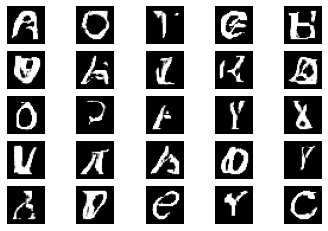

In [ ]:
# load model
model_path = main_models_dir + 'generator_model_075.h5'
model = load_model(model_path) # tf.keras.models.load_model
# generate images
latent_points = generate_latent_points(100, 25)
# generate images
X = model.predict(latent_points)
# plot the result
save_plot(X, 5)

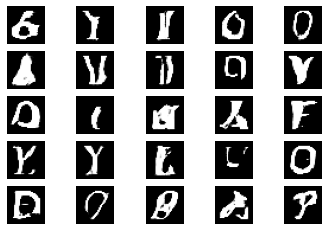

In [ ]:
# load model
model_path = main_models_dir + 'generator_model_050.h5'
model = load_model(model_path) # tf.keras.models.load_model
# generate images
latent_points = generate_latent_points(100, 25)
# generate images
X = model.predict(latent_points)
# plot the result
save_plot(X, 5)

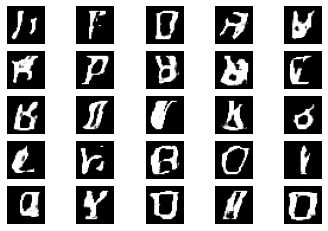

In [ ]:
# load model
model_path = main_models_dir + 'generator_model_025.h5'
model = load_model(model_path) # tf.keras.models.load_model
# generate images
latent_points = generate_latent_points(100, 25)
# generate images
X = model.predict(latent_points)
# plot the result
save_plot(X, 5)

## Generate a single sample (using a vector of all 0.0 values)

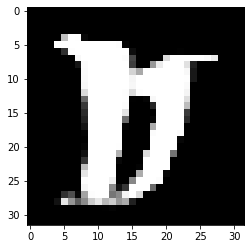

In [ ]:
# load model
model_path = main_models_dir + 'generator_model_100.h5'
model = load_model(model_path) # tf.keras.models.load_model
# all 0s
vector = np.asarray([[1.0 for _ in range(100)]])
# generate image
X = model.predict(vector)
# plot the result
plt.imshow(X[0, :, :, 0], cmap='gray_r')
plt.show()